---
title: "Part2: Implementing Average Precision AP50"
author: "Prathmesh Maharshi"
date: "2025-02-24"
image: "output.png"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
---

In [2]:
import numpy as np
from shapely.geometry import box
import random
import matplotlib.pyplot as plt
import supervision as sv
from matplotlib.patches import Rectangle

In [25]:
def compute_iou_shapely_batch(boxes1, boxes2):
    """
    Compute IoU between two sets of boxes in [x_min, y_min, x_max, y_max] format using Shapely.
    
    Parameters:
    - boxes1 (np.ndarray): Shape (N, 4)
    - boxes2 (np.ndarray): Shape (M, 4)
    
    Returns:
    - np.ndarray: IoU matrix of shape (N, M)
    """
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)
    if boxes1.ndim == 1:
        boxes1 = boxes1.reshape(1, -1)
    if boxes2.ndim == 1:
        boxes2 = boxes2.reshape(1, -1)
    
    N, M = boxes1.shape[0], boxes2.shape[0]
    
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    
    boxes1_shapely = [box(b[0], b[1], b[2], b[3]) for b in boxes1]
    boxes2_shapely = [box(b[0], b[1], b[2], b[3]) for b in boxes2]
    
    iou_matrix = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            intersection = boxes1_shapely[i].intersection(boxes2_shapely[j]).area
            union = area1[i] + area2[j] - intersection
            iou_matrix[i, j] = intersection / union if union > 0 else 0.0
    
    return iou_matrix

In [26]:
def compute_pr_batch(predictions, ground_truths, iou_threshold=0.5):
    if not predictions:
        return np.array([]), np.array([])
    
    pred_boxes = np.array(predictions)
    gt_boxes = np.array(ground_truths)
    
    iou_matrix = compute_iou_shapely_batch(pred_boxes, gt_boxes)
    
    tp = np.zeros(len(predictions))
    fp = np.zeros(len(predictions))
    gt_matched = set()
    
    # Match predictions in order of appearance (no confidence sorting)
    for pred_idx in range(len(predictions)):
        best_iou_idx = np.argmax(iou_matrix[pred_idx])
        best_iou = iou_matrix[pred_idx, best_iou_idx]
        if best_iou >= iou_threshold and best_iou_idx not in gt_matched:
            tp[pred_idx] = 1
            gt_matched.add(best_iou_idx)
        else:
            fp[pred_idx] = 1
    
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    recall = tp_cumsum / (len(ground_truths) + 1e-10)
    return precision, recall

In [27]:
def compute_ap_voc(predictions, ground_truths, iou_threshold=0.5):
    precision, recall = compute_pr_batch(predictions, ground_truths, iou_threshold)
    if precision.size == 0:
        return 0.0
    recall_levels = np.linspace(0, 1, 11)
    prec_at_recall = np.zeros(len(recall_levels))
    for i, r in enumerate(recall_levels):
        valid_precisions = [precision[j] for j in range(len(recall)) if recall[j] >= r]
        prec_at_recall[i] = max(valid_precisions) if valid_precisions else 0.0
    return np.mean(prec_at_recall)

def compute_ap_coco(predictions, ground_truths, iou_threshold=0.5):
    precision, recall = compute_pr_batch(predictions, ground_truths, iou_threshold)
    if precision.size == 0:
        return 0.0
    recall_levels = np.linspace(0, 1, 101)
    precision_levels = np.zeros_like(recall_levels)
    for r, p in zip(recall[::-1], precision[::-1]):
        precision_levels[recall_levels <= r] = p
    return (1 / 101 * precision_levels).sum()

def compute_ap_auc(predictions, ground_truths, iou_threshold=0.5):
    precision, recall = compute_pr_batch(predictions, ground_truths, iou_threshold)
    if precision.size == 0:
        return 0.0
    return np.trapz(precision, recall)

In [28]:
def generate_random_boxes(n_images=10, img_size=100, box_size=20, n_boxes=10):
    images_data = []
    for _ in range(n_images):
        gt_boxes = []
        for _ in range(n_boxes):
            x_min = random.randint(0, img_size - box_size)
            y_min = random.randint(0, img_size - box_size)
            gt_boxes.append([x_min, y_min, x_min + box_size, y_min + box_size])
        
        pred_boxes = []
        for gt in gt_boxes[:int(n_boxes * 0.8)]:  # 80% overlap
            offset = random.randint(-5, 5)
            pred_boxes.append([gt[0] + offset, gt[1] + offset, gt[2] + offset, gt[3] + offset])
        for _ in range(n_boxes - len(pred_boxes)):  # Remaining as FPs
            x_min = random.randint(0, img_size - box_size)
            y_min = random.randint(0, img_size - box_size)
            pred_boxes.append([x_min, y_min, x_min + box_size, y_min + box_size])
        
        images_data.append({"gt": gt_boxes, "pred": pred_boxes})
    return images_data

In [29]:
def compute_ap50_images(images_data, iou_threshold=0.5):
    ap_voc_scores = []
    ap_coco_scores = []
    ap_auc_scores = []
    
    for img_data in images_data:
        gt = img_data["gt"]
        pred = img_data["pred"]
        
        ap_voc = compute_ap_voc(pred, gt, iou_threshold)
        ap_coco = compute_ap_coco(pred, gt, iou_threshold)
        ap_auc = compute_ap_auc(pred, gt, iou_threshold)
        
        ap_voc_scores.append(ap_voc)
        ap_coco_scores.append(ap_coco)
        ap_auc_scores.append(ap_auc)
    
    ap50_voc = np.mean(ap_voc_scores)
    ap50_coco = np.mean(ap_coco_scores)
    ap50_auc = np.mean(ap_auc_scores)
    
    return ap50_voc, ap50_coco, ap50_auc

In [30]:
def plot_boxes(images_data, img_size=100):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (img_data, ax) in enumerate(zip(images_data, axes)):
        gt_boxes = img_data["gt"]
        pred_boxes = img_data["pred"]
        
        for gt in gt_boxes:
            x, y, x_max, y_max = gt
            rect = Rectangle((x, y), x_max - x, y_max - y, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 2, 'GT', color='g', fontsize=8, ha='left', va='bottom')
        
        for pred in pred_boxes:
            x, y, x_max, y_max = pred
            rect = Rectangle((x, y), x_max - x, y_max - y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 2, 'Pred', color='r', fontsize=8, ha='left', va='bottom')
        
        ax.set_xlim(0, img_size)
        ax.set_ylim(0, img_size)
        ax.set_title(f'Image {i+1}')
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

AP50 (VOC 11-point): 0.3409
AP50 (COCO 101-point): 0.3317
AP50 (AUC): 0.2619


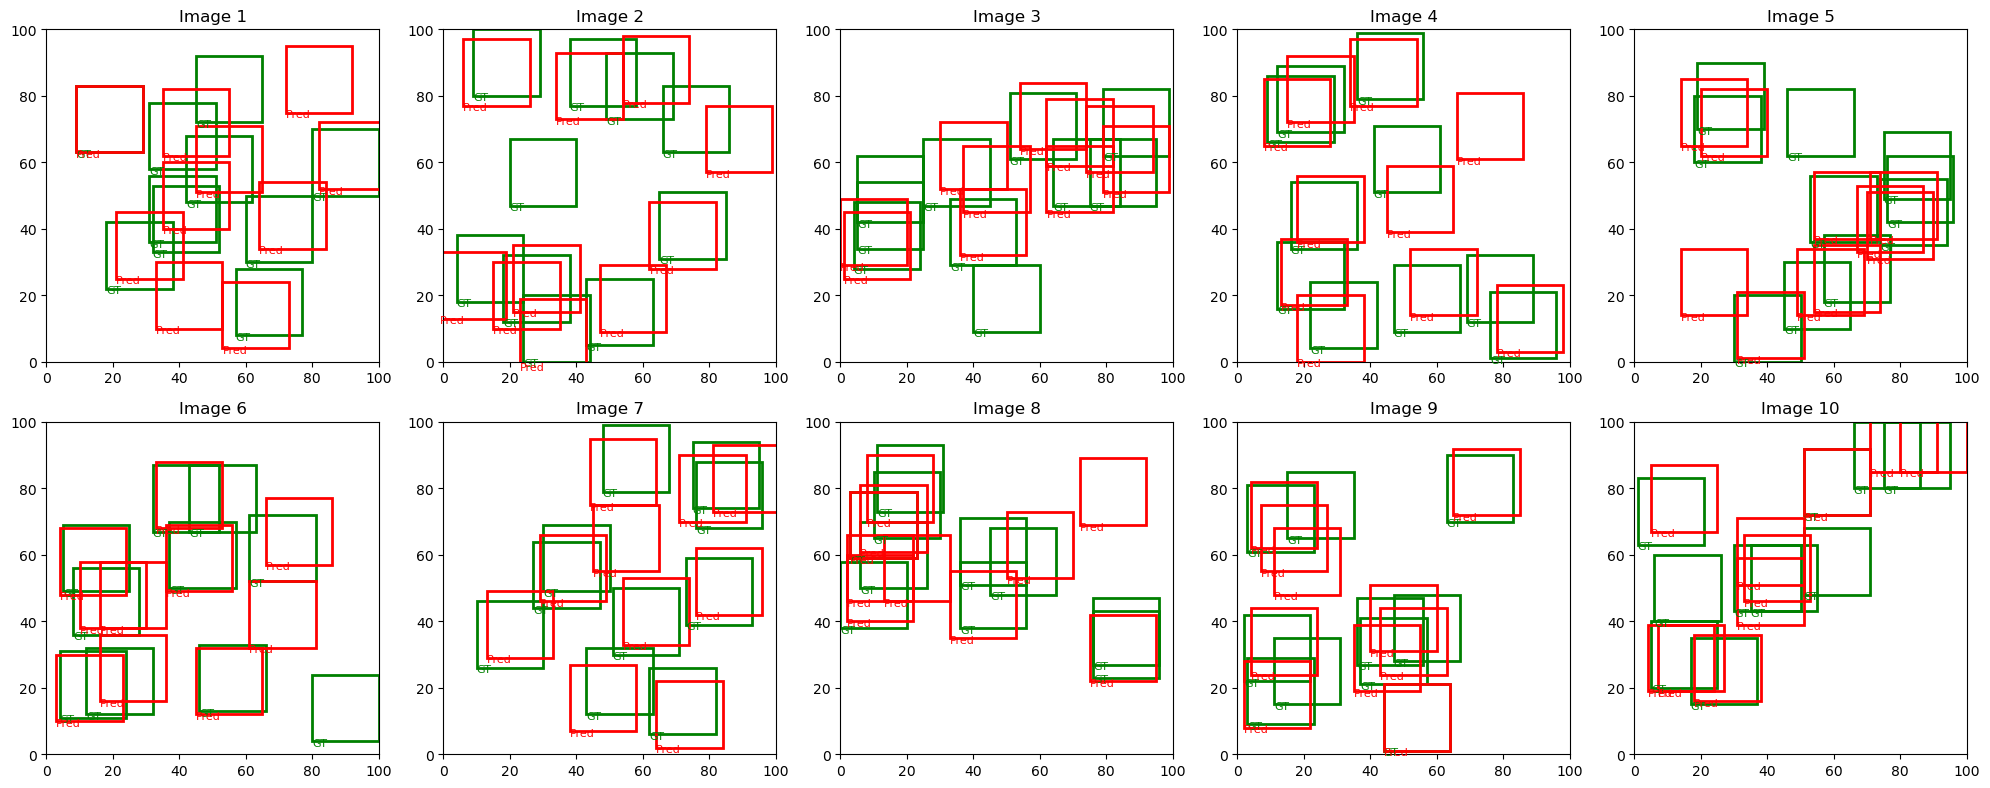

In [31]:
images_data = generate_random_boxes(n_images=10, img_size=100, box_size=20, n_boxes=10)
ap50_voc, ap50_coco, ap50_auc = compute_ap50_images(images_data, iou_threshold=0.5)

print(f"AP50 (VOC 11-point): {ap50_voc:.4f}")
print(f"AP50 (COCO 101-point): {ap50_coco:.4f}")
print(f"AP50 (AUC): {ap50_auc:.4f}")

plot_boxes(images_data, img_size=100)